In [1]:
%matplotlib inline


sDTW multi path matching
========================

This example illustrates how subsequent DTW can be used to find multiple
matches of a sequence in a longer sequence.

A potential usecase is to identify the occurrence of certain events in
continuous sensor signals. As one example Barth et al. [1] used this method
to find stride in sensor recordings of gait.

The example demonstrates the use of the functions
`subsequence_cost_matrix` and `subsequence_path`
to manually calculate warping paths from multiple potential alignments. If
you are only interested in finding the optimal alignment, you can directly use
`dtw_subsequence_path`.

[1] Barth, et al. (2013): Subsequence dynamic time warping as a method for \
robust step segmentation using gyroscope signals of daily life activities, \
EMBS, https://doi.org/10.1109/EMBC.2013.6611104


Shape long sequence: (500, 1)
Shape short sequence: (100, 1)


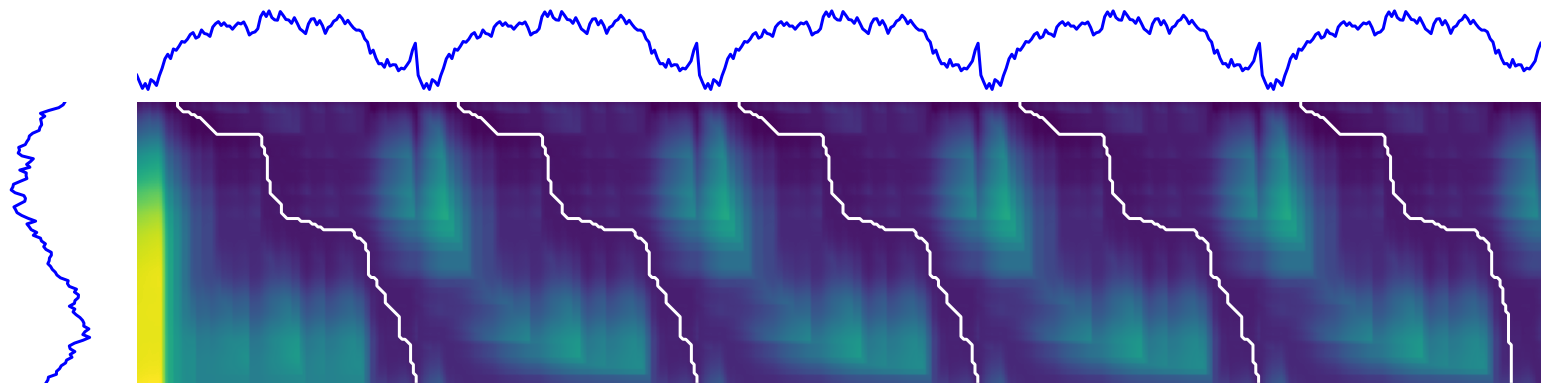

In [2]:
# Author: Arne Kuederle
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy
from scipy.signal import find_peaks

from tslearn import metrics
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

numpy.random.seed(0)
n_ts, sz, d = 2, 100, 1
n_repeat = 5
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset_scaled = scaler.fit_transform(dataset)

# We repeat the long sequence multiple times to generate multiple possible
# matches
long_sequence = numpy.tile(dataset_scaled[1], (n_repeat, 1))
short_sequence = dataset_scaled[0]

sz1 = len(long_sequence)
sz2 = len(short_sequence)

print('Shape long sequence: {}'.format(long_sequence.shape))
print('Shape short sequence: {}'.format(short_sequence.shape))

# Calculate the accumulated cost matrix
mat = metrics.subsequence_cost_matrix(short_sequence,
                                      long_sequence)

# Calculate cost function
cost_func = mat[-1, :]

# Identify potential matches in the cost function (parameters are tuned to
# fit this example)
potential_matches = find_peaks(-cost_func, distance=sz * 0.75, height=-50)[0]

# Calculate the optimal warping path starting from each of the identified
# minima
paths = [metrics.subsequence_path(mat, match) for match in
         potential_matches]

plt.figure(1, figsize=(6 * n_repeat, 6))

# definitions for the axes
left, bottom = 0.01, 0.1
h_ts = 0.2
w_ts = h_ts / n_repeat
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

ax_gram.imshow(numpy.sqrt(mat))
ax_gram.axis("off")
ax_gram.autoscale(False)

# Plot the paths
for path in paths:
    ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
                 linewidth=3.)

ax_s_x.plot(numpy.arange(sz1), long_sequence, "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz1 - 1))

ax_s_y.plot(- short_sequence, numpy.arange(sz2)[::-1], "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz2 - 1))

plt.show()